In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as st

from matplotlib import pyplot as plt
from datetime import date, datetime, timedelta

import matplotlib.ticker as ticker
import matplotlib.dates as mdates


In [2]:
pd.options.display.max_rows = 100        #Increases the number of rows displayed without a break in the middle.
pd.options.display.max_columns = 100     #Increases the number of columns displayed without a break in the middle.
pd.set_option('max_colwidth',100)        #Increases the width of the columns to display 100 characters at the same time.

# Data Source

538 periodically and generously updates the polls they use on Github for their analysis of national elections. You can find the link here:
https://github.com/fivethirtyeight/data/tree/master/polls



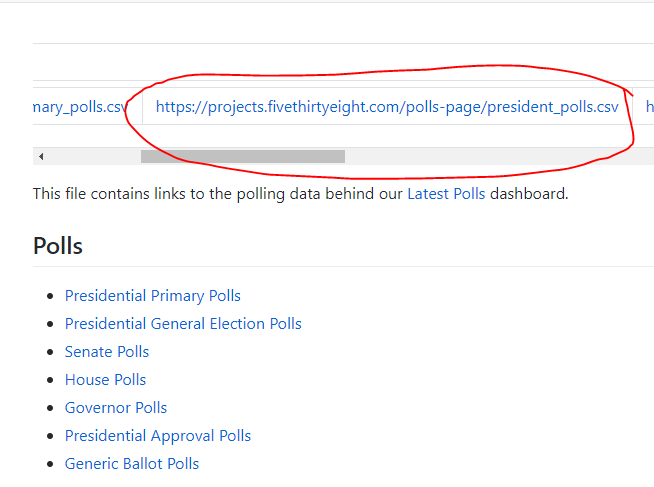

# Here are functions to allow you to read, save, plot, and analyze the polling data

In [3]:
def read_poll_data():
    
    # 538's polling data is updated on Github hourly, so this checks to see if this poll was published this hour. 
    now = pd.to_datetime('now')
    root = '-{}-{}-{}-{}hours'.format(now.year,now.month,now.day,now.hour)
    
    if os.path.exists('./presidential_polls{}.pkl'.format(str(root))):
        df = pd.read_pickle('./presidential_polls{}.pkl'.format(str(root)))

    else:
        presidential_polls_url = "https://projects.fivethirtyeight.com/polls-page/president_polls.csv"
        df = pd.read_csv(presidential_polls_url)  # read presidential poll data
        df.state = df.state.fillna("National")    # fill na values for the state to indicate National polls
        df.to_pickle('./presidential_polls{}.pkl'.format(str(root)))
        
    return df

In [4]:
def get_poll_data(poll_location = "National", poll_type = "lv", smoothing_distance = 22, exclude_online_only_polls = True):

    df = read_poll_data()
    df = df.loc[(df.population==poll_type)&(df.state==poll_location)]  # select only lv for likely votetr or rv for registered voter
    
    if exclude_online_only_polls:
        
        df = df.loc[df.methodology != "Online"]
        
        #Use this code if you would like to exclude any form of online poll
        #df = df[~df.methodology.str.contains("Online") == True]
        
    index = [df.question_id, df.end_date, df.sample_size]
    df = pd.crosstab(index, df.candidate_name, df.pct, aggfunc = "sum", colnames = ['index'])[["Joseph R. Biden Jr.", "Donald Trump"]].dropna()
    df = df.rename(columns = {"Joseph R. Biden Jr.":"biden","Donald Trump":"trump"})
    df = df.reset_index()
    df.end_date = pd.to_datetime(df.end_date)
    df["other"] = abs(df["biden"]-df["trump"])

    # use a lowess smoother to smooth the results and calculate the residual errors
    smoothed_df =  pd.DataFrame(df['end_date'].copy())
    
    
    for col in ["biden","trump","other"]:

        smooth_col_name = col+'_smooth'
        smoothed_df[smooth_col_name] = smooth(df[col], smoothing_distance)
    
    # consolidate smoothing around the dates to ensure same smoothed values on the same day.
    smoothed_df = smoothed_df.groupby(by = "end_date").mean()
    smoothed_df = smoothed_df.reset_index()
    df = pd.merge(df,smoothed_df, how = 'left', left_on = 'end_date', right_on = 'end_date' )

    # calculate residual errors 
    for col in ["biden","trump","other"]:   
        err_col_name = col+'_residual_err'
        smooth_col_name = col+'_smooth'
        df[err_col_name] = df[col]-df[smooth_col_name]
        
    
    # calculate prediction intervals 
    for col in ["biden","trump","other"]:  
        
        # assign col names
        
        col_high = col+'_high'
        col_low =  col+'_low'
        
        # male calculations
        err_col_name = col+'_residual_err'
        smooth_col_name = col+'_smooth'
        
        x = df[err_col_name].values   # values
        m, m_low, m_high, sigma = intervals(x)
        
        df[col_low] = df[smooth_col_name]+m_low
        df[col_high] = df[smooth_col_name]+m_high
        df = df.sort_values('end_date')
        
    return (df)

In [5]:
def intervals(data, confidence=.9973):
    
    import scipy.stats
    
    a = 1.0 * np.array(data)
    n = len(a)
    mu, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    sigma = np.std(data)
    
    return mu, mu-h, mu+h,sigma

In [6]:
def smooth(y_series, smoothing_distance=5, smoothing_iterations = 3, fill_missing = True, allow_negative_values = False):

    import statsmodels.api as sm
    
    y_series = y_series.fillna(0) # replace all NaN values with 0
    x_series = list(np.arange(0,len(y_series),1))
    
    # set lowess_window_length
    
    if smoothing_distance >= len(x_series):
        lowess_window_length = len(x_series)
    
    else: 
        lowess_window_length = smoothing_distance
        
    window = lowess_window_length/len(x_series)
    
    
    if allow_negative_values == False:
        y_series[y_series < 0] = 0  #replace all values less than zero with 0
    
    # if the dataset has NaN values, they will be replaced with linear interpolation
    if fill_missing == True:
        y_series = y_series.replace(to_replace=0, value = None).interpolate(method='linear')
        y_series = y_series.fillna(0)
    
    #log transform the series
    y_series = np.log1p(y_series)
    
    lowess = sm.nonparametric.lowess
    smooth = lowess(y_series, x_series, frac = window, it = smoothing_iterations)
    index, yhat = np.transpose(smooth)
    
    #reverse transform the series by taking the inverse log 1p
    yhat = np.expm1(yhat)
    
    return yhat

In [7]:
def plot_polls(df,days_to_subtract,poll_location,poll_type):
    
    df = df.sort_values('end_date')
    cutoff_date = datetime.today() - timedelta(days=days_to_subtract)
    df = df.loc[df.end_date >= cutoff_date]

    thousands_formatter = ticker.StrMethodFormatter('{x:,.0f}%')
    #date_formatter = mdates.DateFormatter('%b\'%y')

    if poll_type == "rv":
        polling_title = "Registered Voter"
    else:
        polling_title = "Likely Voter"

    fig = plt.figure(figsize = (15,10))
    ax1 = plt.subplot2grid((60, 4), (0, 0),  rowspan=10, colspan=4)
    ax2 = plt.subplot2grid((60, 4), (12, 0), rowspan=40, colspan=4)


    # plot title
    figure_title = "{} - {} Polls - {} Day Trend".format(poll_location, polling_title, days_to_subtract)
    figure_source_text = "DATA SOURCE: Data published on Github by 538: (This excludes polls administered only online.)\nLocation:  https://projects.fivethirtyeight.com/polls-page/president_polls.csv"
    ax1.text(0, 0.45, figure_title, fontsize=30, fontweight='normal')
    ax1.text(0, 0.01, figure_source_text, fontsize=14, fontweight='normal')
    ax1.axis('off')

    # plot the daily values
    ax2.scatter(df["end_date"], df["trump"], facecolors="salmon", edgecolors="darkred", label = "Trump's Polls (Sample Size) ", s = df.sample_size/10, linewidth = 0.55)
    ax2.scatter(df["end_date"], df["biden"], facecolors="lightblue", edgecolors="darkblue", label = "Biden's Polls (Sample Size)", s = df.sample_size/10, alpha = 1, linewidth = 0.55)

    ax2.plot(df["end_date"], df["trump_smooth"], linestyle = '--', linewidth = 2, color = "salmon", alpha = 1)
    ax2.plot(df["end_date"], df["biden_smooth"], linestyle = '--', linewidth = 2, color = "dodgerblue", alpha = 1)

    ax2.fill_between(df["end_date"], df['biden_low'], df['biden_high'], color = 'dodgerblue', alpha = 0.15 )
    ax2.fill_between(df["end_date"], df['trump_low'], df['trump_high'], color = 'salmon', alpha = 0.15 )

    ax2.axvline(x = df["end_date"].max(), linestyle = '--', color = 'red', label = "Now", linewidth = 1)
    ax2.axvline(x = pd.to_datetime('2020-11-3'), linestyle = '--', color = 'brown', label = 'Election Day', linewidth = 3)

    ax2.set_xlim(df["end_date"].min(), pd.to_datetime('2020-11-7'))
    ax2.set_ylim(min([df["trump"].min(),df["biden"].min()])*.90, max([df["trump"].max(),df["biden"].max()])*1.10)

    ax2.tick_params(axis='x', labelsize = 12)
    ax2.tick_params(axis='y', labelsize = 19)
    ax2.yaxis.set_major_formatter(thousands_formatter)
    #ax2.xaxis.set_major_formatter(date_formatter)
    ax2.legend(loc = 2, prop={'size': 14})

    plt.show()

In [8]:
def main(poll_location, poll_type, days_to_subtract, smoothing_distance, plot_data = True):
    
    df = get_poll_data(poll_location, poll_type, smoothing_distance, exclude_online_only_polls = True)
    
    if plot_data:
        plot_polls(df,days_to_subtract,poll_location,poll_type)
        
    return df

# Here is how you can read in the raw polling data to do your analysis. It excludes "online" only polls.

In [9]:
df = read_poll_data()

display(df.head(2))
display(df.tail(2))

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,pollster_rating_name,fte_grade,sample_size,population,population_full,methodology,office_type,seat_number,seat_name,start_date,end_date,election_date,sponsor_candidate,internal,partisan,tracking,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
0,135481,72217,2020,Arizona,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,Rasmussen Reports/Pulse Opinion Research,C+,800.0,lv,lv,IVR/Online,U.S. President,0,NaN,10/27/20,10/29/20,11/3/20,NaN,False,NaN,NaN,False,False,10/29/20 13:29,NaN,https://www.rasmussenreports.com/public_content/politics/elections/election_2020/arizona_trump_4...,general,6214,Biden,13256,Joseph R. Biden Jr.,DEM,45.0
1,135481,72217,2020,Arizona,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,Rasmussen Reports/Pulse Opinion Research,C+,800.0,lv,lv,IVR/Online,U.S. President,0,NaN,10/27/20,10/29/20,11/3/20,NaN,False,NaN,NaN,False,False,10/29/20 13:29,NaN,https://www.rasmussenreports.com/public_content/politics/elections/election_2020/arizona_trump_4...,general,6214,Trump,13254,Donald Trump,REP,49.0


,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,pollster_rating_name,fte_grade,sample_size,population,population_full,methodology,office_type,seat_number,seat_name,start_date,end_date,election_date,sponsor_candidate,internal,partisan,tracking,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
14722,92078,57025,2020,National,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,Rasmussen Reports/Pulse Opinion Research,C+,1000.0,lv,lv,IVR/Online,U.S. President,0,NaN,11/12/18,11/13/18,11/3/20,NaN,False,NaN,NaN,False,False,12/6/18 14:40,NaN,http://www.rasmussenreports.com/public_content/politics/general_politics/november_2018/michelle_...,general,6210,Obama,13253,Michelle Obama,DEM,50.0
14723,92078,57025,2020,National,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,Rasmussen Reports/Pulse Opinion Research,C+,1000.0,lv,lv,IVR/Online,U.S. President,0,NaN,11/12/18,11/13/18,11/3/20,NaN,False,NaN,NaN,False,False,12/6/18 14:40,NaN,http://www.rasmussenreports.com/public_content/politics/general_politics/november_2018/michelle_...,general,6210,Trump,13254,Donald Trump,REP,43.0


# Plot the national level polls of "likely voters."

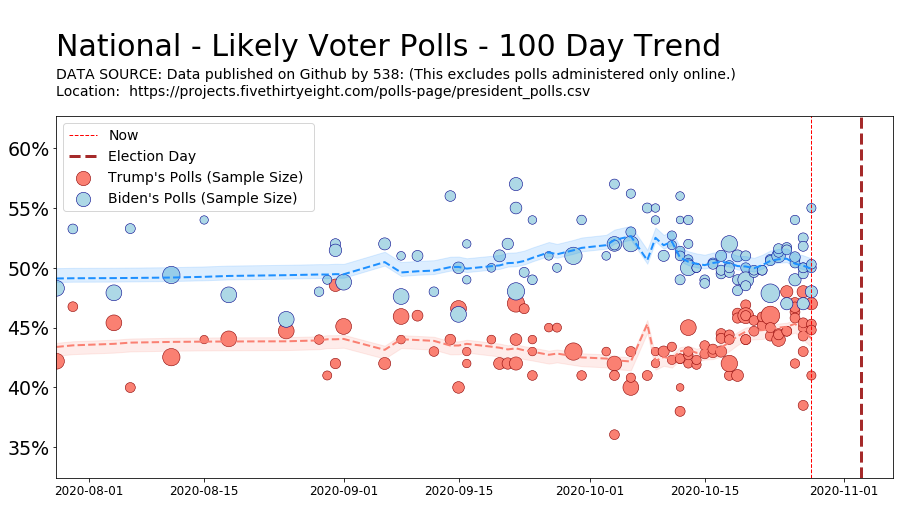

In [10]:
df = main(poll_location = 'National',
          poll_type = 'lv', 
          days_to_subtract = 100,
          smoothing_distance = 22, 
          plot_data = True)

# Plot the national level polls of "registered voters."

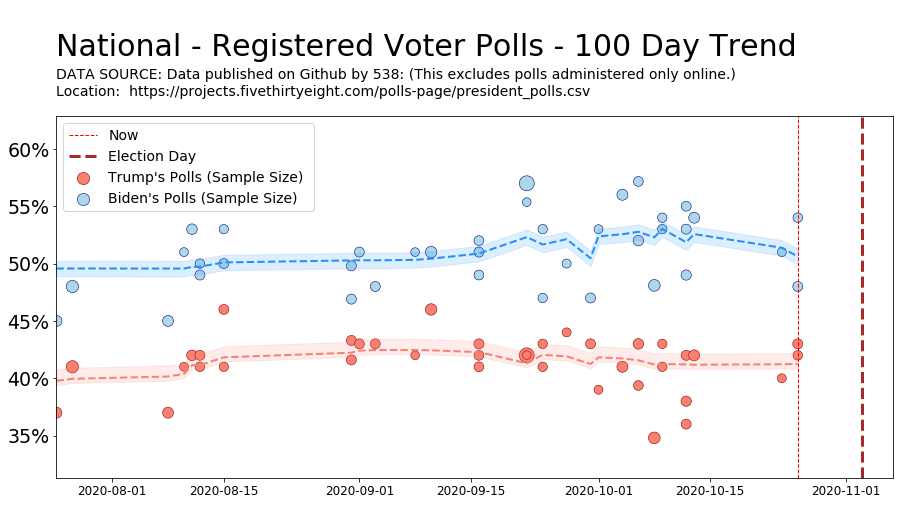

In [11]:
df = main(poll_location = 'National',
          poll_type = 'rv', 
          days_to_subtract = 100,
          smoothing_distance = 22, 
          plot_data = True)

# Plot all likely voters in a list of states to watch of "swing states." 

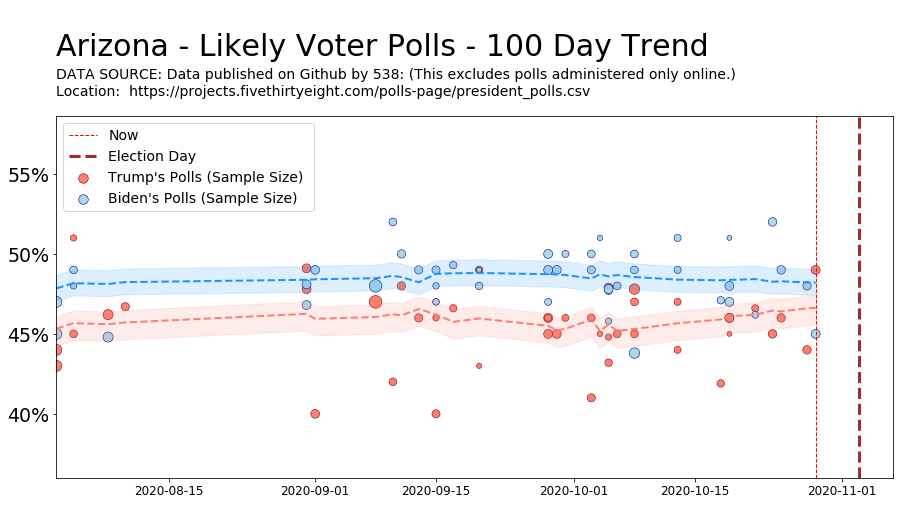

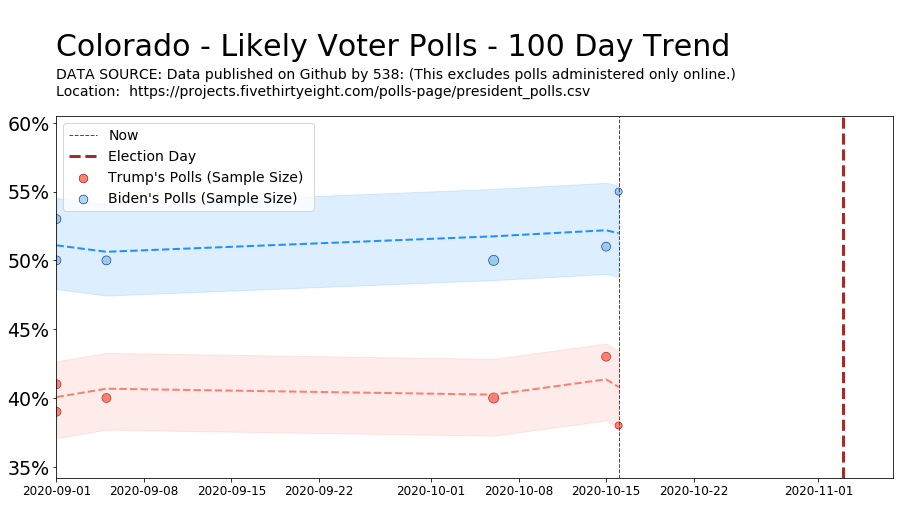

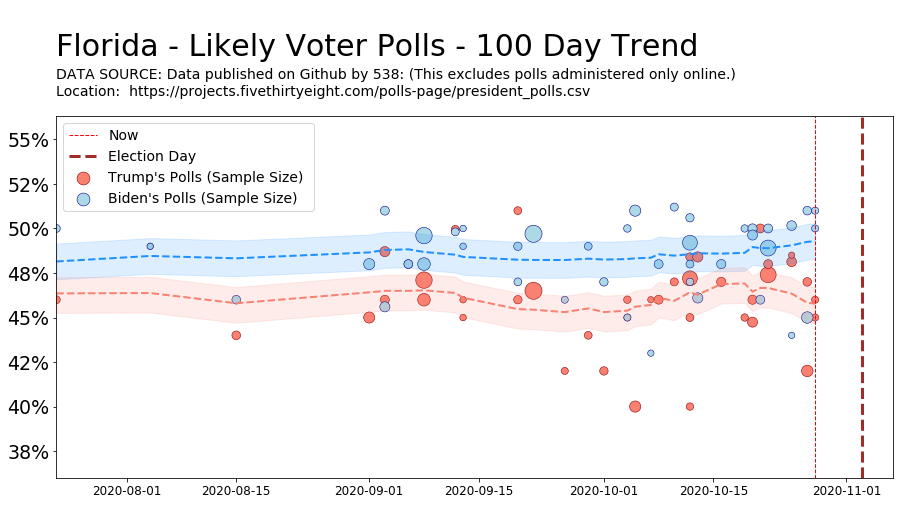

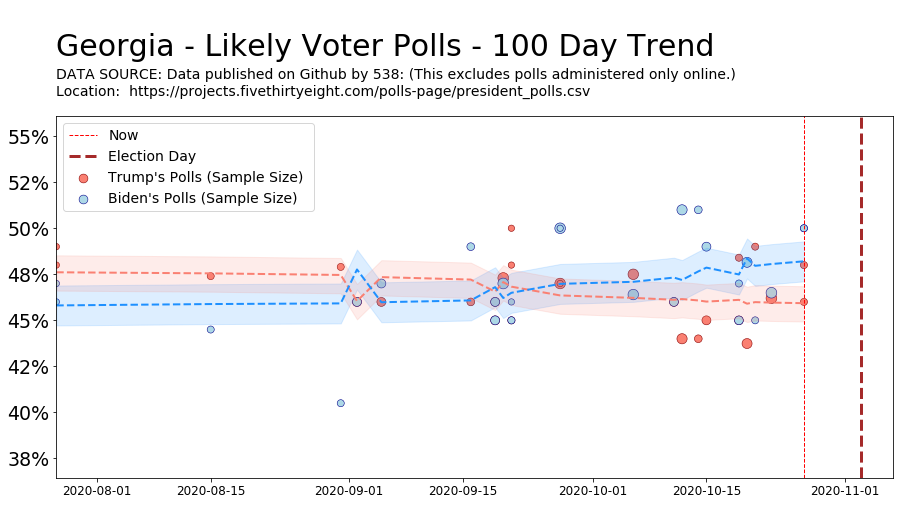

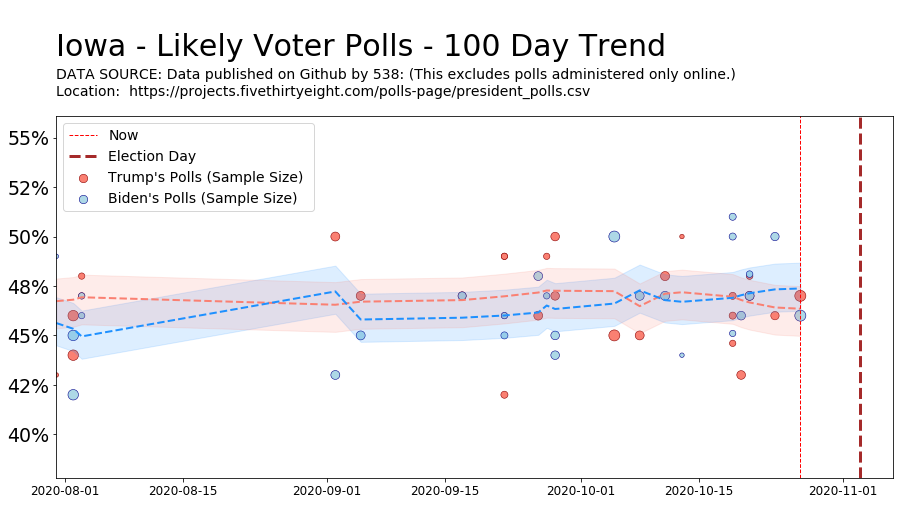

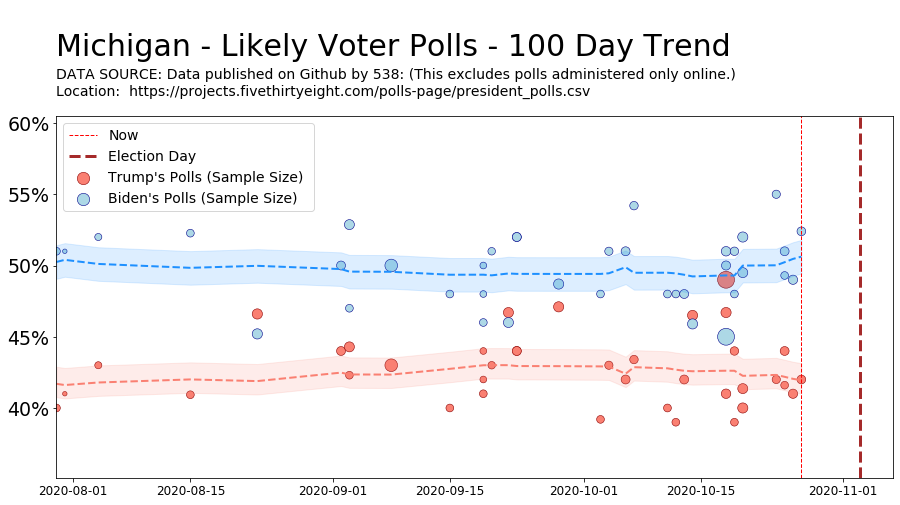

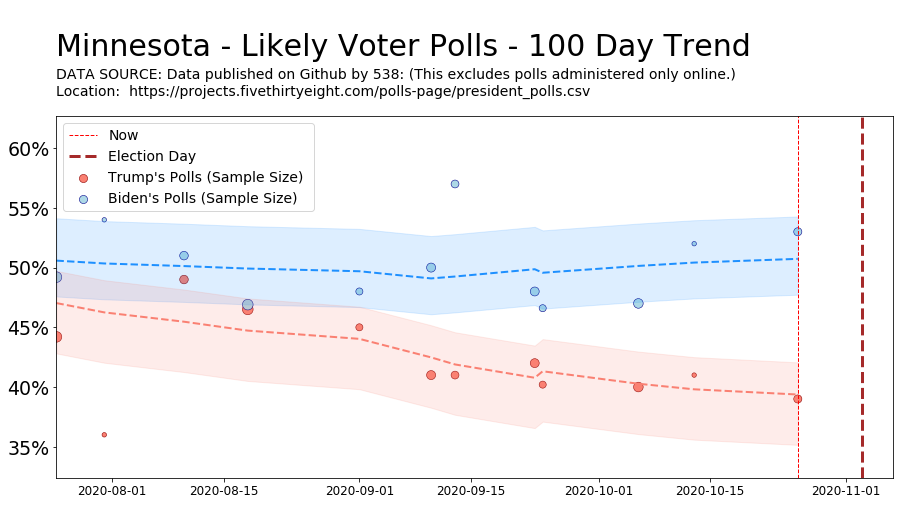

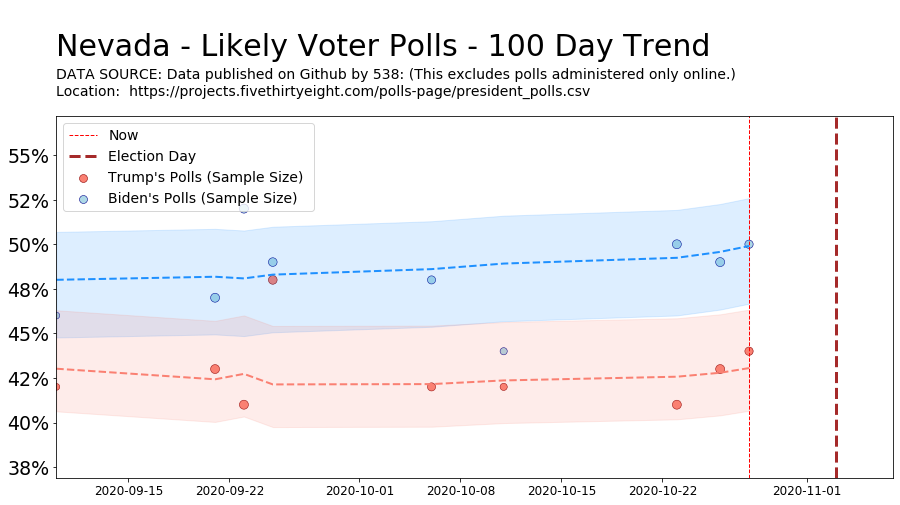

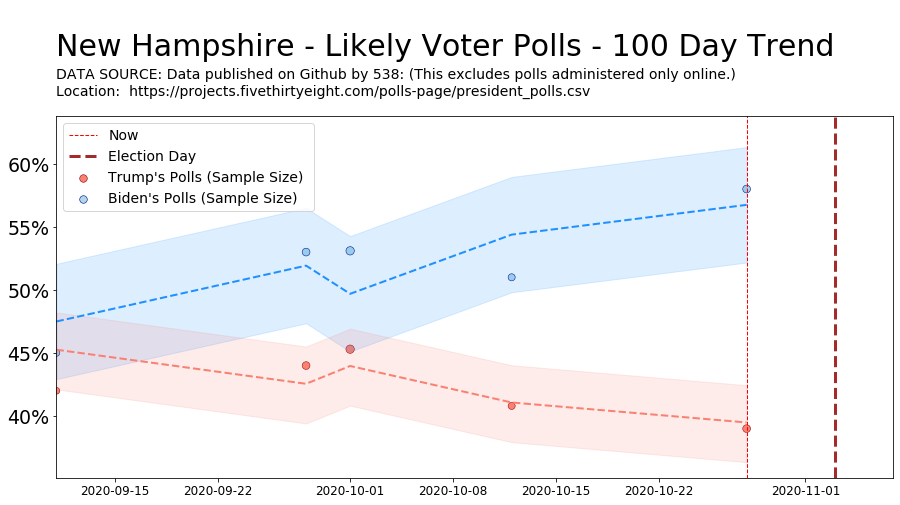

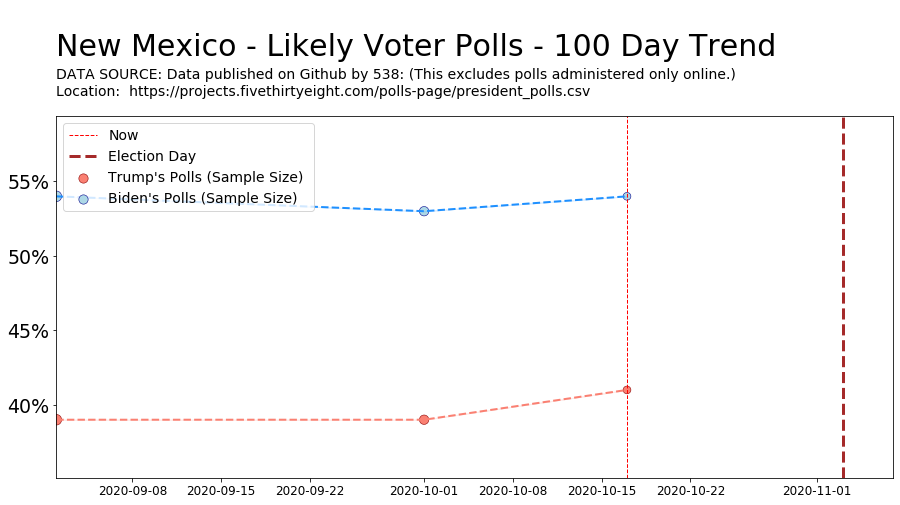

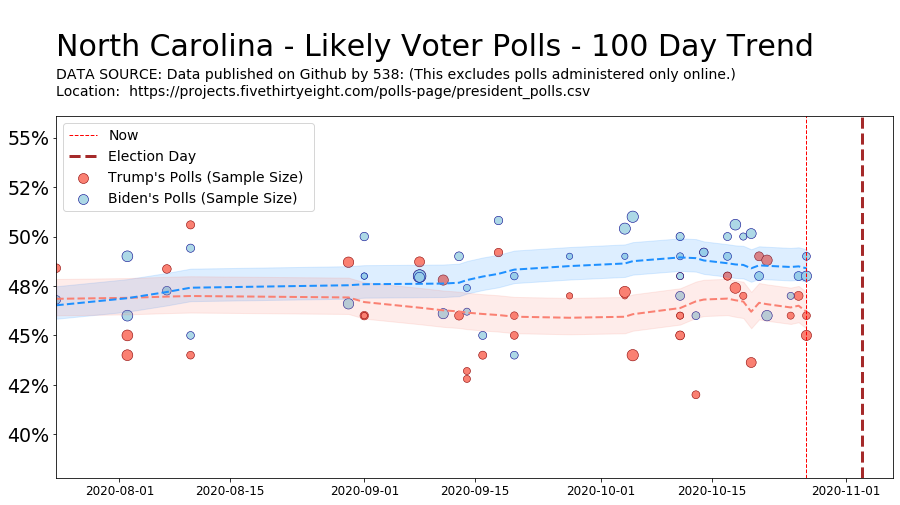

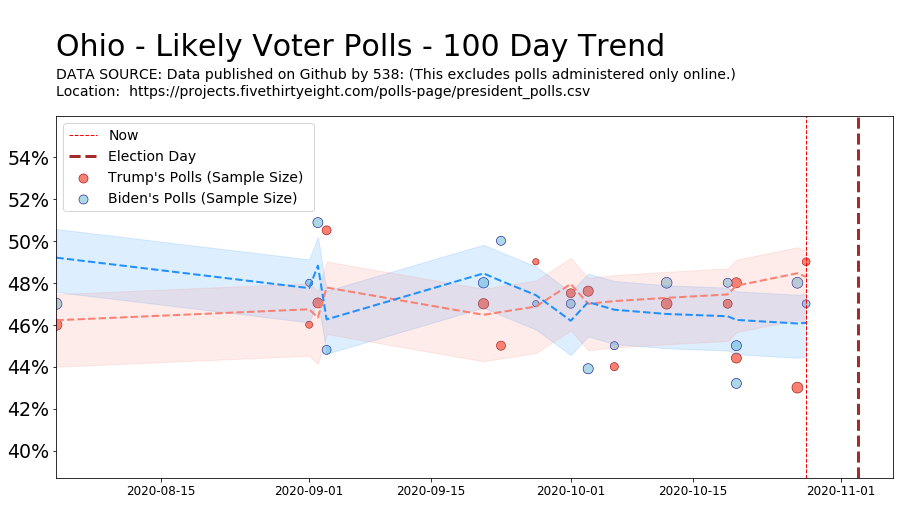

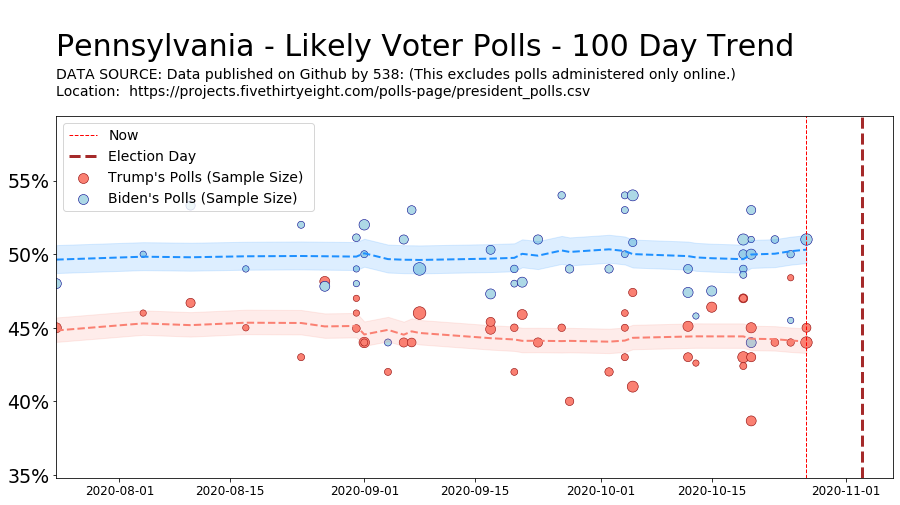

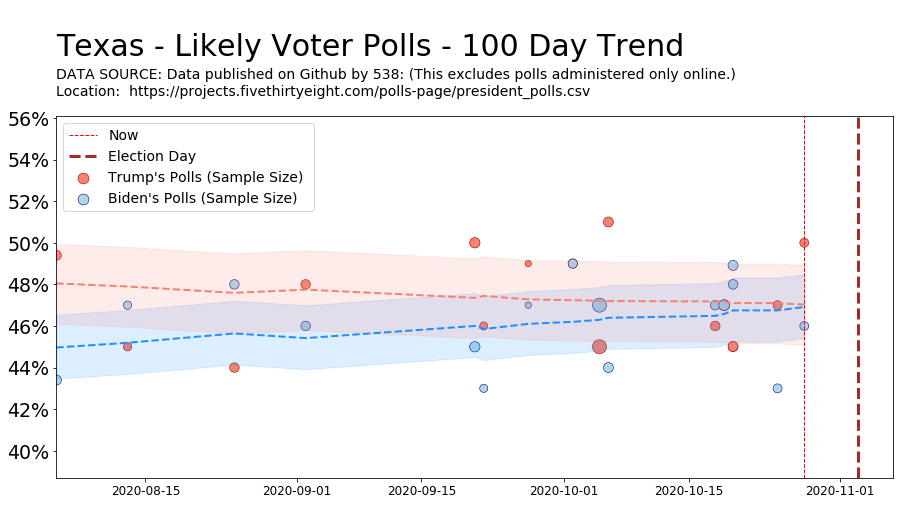

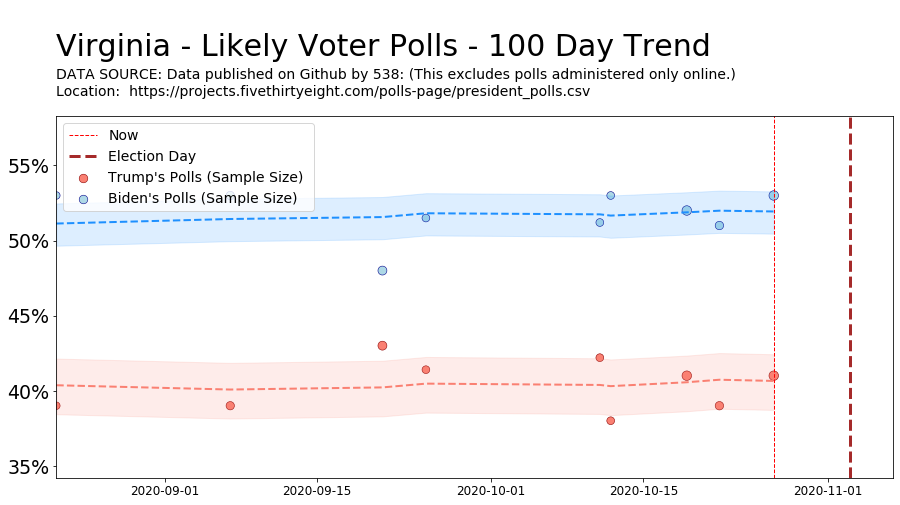

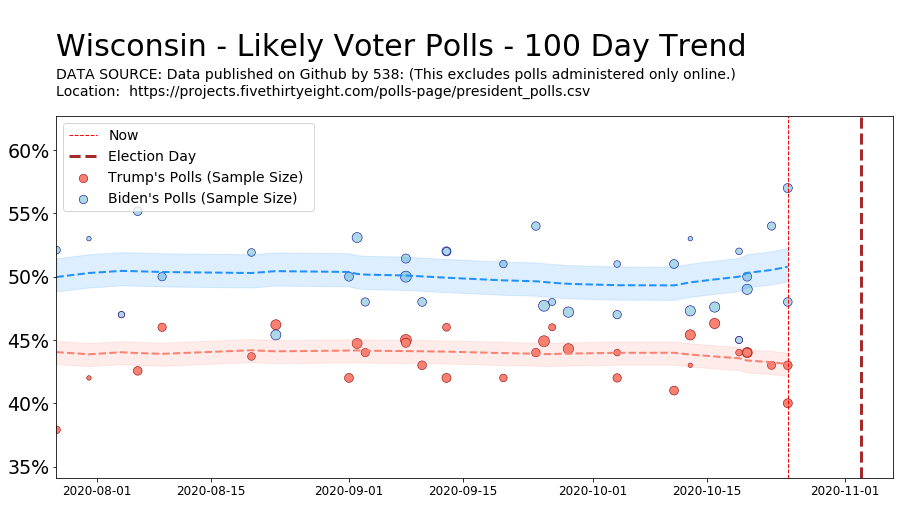

In [12]:
list_of_states_to_watch = ['Arizona','Colorado','Florida','Georgia','Iowa',
                           'Michigan','Minnesota','Nevada','New Hampshire','New Mexico','North Carolina',
                           'Ohio','Pennsylvania','Texas','Virginia','Wisconsin']

for state in list_of_states_to_watch:
    
    df = main(poll_location = state,
              poll_type = 'lv', 
              days_to_subtract = 100,
              smoothing_distance = 22, 
              plot_data = True)
